In [1]:
# Load necessary libraries
if (!requireNamespace("readxl", quietly = TRUE)) install.packages("readxl")
if (!requireNamespace("googlesheets4", quietly = TRUE)) install.packages("googlesheets4") # nolint: line_length_linter.

library(readxl)
library(googlesheets4)


In [2]:
# Define input and output paths
input_path <- "https://docs.google.com/spreadsheets/d/1m3eEaxWT4Unb8jBZWKjiLivavfA0x3PT1F1Rz1eXwVE/edit?gid=0" # nolint
output_path <- "https://docs.google.com/spreadsheets/d/1RzC3DfKNUwYA-qfUN0i53hUwRkWGMBOCoYQqdqG4MQY/edit?gid=0" # nolint

local_input_path <- "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\RegressionDF_forR.csv" # nolint

regression_df <- read.csv(local_input_path)
print(regression_df)


          date       regiao mental_health_visits total_visits periodo
1   2024-12-01          sul               169359      5537357     108
2   2022-07-01          sul               147159      5670166      79
3   2022-11-01          sul               160759      6053194      83
4   2022-10-01          sul               165405      5938846      82
5   2022-09-01          sul               168925      5776479      81
6   2018-04-01          sul                97726      3954977      28
7   2018-05-01          sul                94476      3950949      29
8   2018-06-01          sul                88737      3629643      30
9   2022-08-01          sul               177835      6446181      80
10  2022-06-01          sul               140293      5884884      78
11  2022-02-01          sul               112740      4736730      74
12  2018-07-01          sul                94076      3895748      31
13  2018-08-01          sul               102565      4238054      32
14  2018-09-01      

# Imports

In [18]:
install.packages(c("glmmTMB", "lme4", "performance", "DHARMa", "ggplot2", "ggeffects", "purrr", "emmeans", "performance", "dplyr", "patchwork", "see", "broom.mixed", "dotwhisker", "tidyr", "stringr"))
library(glmmTMB) # For NB GLMM with autocorrelation
library(lme4) # Alternative for basic GLMM
library(performance) # For model checks
library(DHARMa) # For residual diagnostics
library(ggplot2) # For plots
library(ggeffects)
library(purrr)
library(emmeans)
library(performance)
library(dplyr)
library(patchwork)
library(see)
library(broom.mixed)
library(dotwhisker)
library(tidyr)
library(stringr)


Warning message:
"os pacotes 'glmmTMB', 'lme4', 'performance', 'DHARMa', 'ggplot2', 'ggeffects', 'purrr', 'emmeans', 'performance', 'dplyr', 'patchwork', 'see', 'broom.mixed', 'dotwhisker', 'tidyr' estão em uso e não serão instalados"
Instalando pacote em 'C:/Users/Lucas/AppData/Local/R/win-library/4.5'
(como 'lib' não foi especificado)



pacote 'stringr' desempacotado com sucesso e somas MD5 verificadas

Os pacotes binários baixados estão em
	C:\Users\Lucas\AppData\Local\Temp\Rtmpo7QTpS\downloaded_packages


In [ ]:
options(repr.plot.width = 16, repr.plot.height = 8) # Para Jupyter Notebook/RMarkdown


# Model Run

In [4]:
# Encontrar o primeiro período onde Pandemia_Step == 1
pandemic_start_info <- regression_df %>%
  filter(Pandemia_Step == 1) %>%
  arrange(periodo) %>%
  slice(1) # Pega a primeira ocorrência

pandemic_start_date <- pandemic_start_info$periodo
print(pandemic_start_date)

DUMMIES_LIST <- c("Pandemia_Step", "Pandemia_Trend", "PosPandemia_Step", "PosPandemia_Trend")

REGIOES_LIST <- unique(regression_df$regiao)
REGIOES_LIST


[1] 52


[1] "sul"          "sudeste"      "norte"        "nordeste"     "centro_oeste"

# Region Models

In [ ]:
region_models <- regression_df %>%
  group_by(regiao) %>%
  group_map(~ tidy(
    glmmTMB(
      mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +
        PosPandemia_Step + PosPandemia_Trend
      #+ offset(log(total_visits / 1000)),
      ,
      family = nbinom2(),
      offset = log(total_visits / 1000),
      data = .x
    )
  ))

# Combine results
region_results <- region_models %>%
  setNames(unique(regression_df$regiao)) %>%
  bind_rows(.id = "regiao")

region_results


regiao,effect,component,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
sul,fixed,cond,(Intercept),2.360551017,0.0261846904,90.1500449,0.000000e+00
sul,fixed,cond,periodo,0.019068022,0.0008803526,21.6595282,4.942698e-104
sul,fixed,cond,Pandemia_Step,-0.043791942,0.0453473586,-0.9657000,3.341943e-01
sul,fixed,cond,Pandemia_Trend,-0.022474634,0.0027698225,-8.1141063,4.893731e-16
sul,fixed,cond,PosPandemia_Step,-0.502265018,0.0552176338,-9.0960982,9.363534e-20
sul,fixed,cond,PosPandemia_Trend,-0.015327835,0.0018706821,-8.1937142,2.532860e-16
sudeste,fixed,cond,(Intercept),1.715604625,0.0196119111,87.4776874,0.000000e+00
sudeste,fixed,cond,periodo,0.019697739,0.0006568553,29.9879440,1.409417e-197
sudeste,fixed,cond,Pandemia_Step,0.257135210,0.0342747287,7.5021808,6.276474e-14


In [33]:
# Make the incidence ratio table
ir_table <- region_results %>%
  filter(term %in% c("Pandemia_Step", "Pandemia_Trend", "PosPandemia_Step", "PosPandemia_Trend")) %>%
  mutate(IR = exp(estimate)) %>%
  select(regiao, term, IR) %>%
  pivot_wider(
    names_from = term,
    values_from = IR,
    names_prefix = "IR_"
  )

ir_table


regiao,IR_Pandemia_Step,IR_Pandemia_Trend,IR_PosPandemia_Step,IR_PosPandemia_Trend
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
sul,0.9571531,0.9777760,0.6051584,0.9847890
sudeste,1.2932200,0.9831800,0.9190870,0.9944183
norte,0.9735107,0.9888103,0.7726498,0.9989683
nordeste,1.1140973,0.9811833,0.7177843,0.9902060
centro_oeste,1.1861041,0.9875918,0.9469542,1.0035247


In [34]:
ir_table <- region_results %>%
  # keep only the four intervention terms
  filter(term %in% c(
    "Pandemia_Step",
    "Pandemia_Trend",
    "PosPandemia_Step",
    "PosPandemia_Trend"
  )) %>%
  # compute IR = exp(estimate)
  mutate(IR = exp(estimate)) %>%
  # select the pieces we need
  select(regiao, term, IR, p.value) %>%
  # pivot so that each term becomes its own pair of columns
  pivot_wider(
    names_from  = term,
    values_from = c(IR, p.value),
    names_glue  = "{.value}_{term}"
  ) %>%
  # (optional) rename the p.value_… cols to something shorter
  rename_with(~ str_replace(.x, "p.value_", "P_value_"), starts_with("p.value_")) %>%
  # (optional) round for presentation
  mutate(
    across(starts_with("IR_"), ~ round(.x, 2)),
    across(starts_with("P_"), ~ signif(.x, 3))
  )

ir_table


regiao,IR_Pandemia_Step,IR_Pandemia_Trend,IR_PosPandemia_Step,IR_PosPandemia_Trend,P_value_Pandemia_Step,P_value_Pandemia_Trend,P_value_PosPandemia_Step,P_value_PosPandemia_Trend
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sul,0.96,0.98,0.61,0.98,3.34e-01,4.89e-16,9.36e-20,2.53e-16
sudeste,1.29,0.98,0.92,0.99,6.28e-14,5.77e-16,4.26e-02,8.75e-05
norte,0.97,0.99,0.77,1.00,5.17e-01,7.98e-06,3.37e-07,5.47e-01
nordeste,1.11,0.98,0.72,0.99,1.79e-03,3.40e-19,1.98e-15,5.36e-12
centro_oeste,1.19,0.99,0.95,1.00,2.81e-09,1.37e-12,1.16e-01,3.27e-03


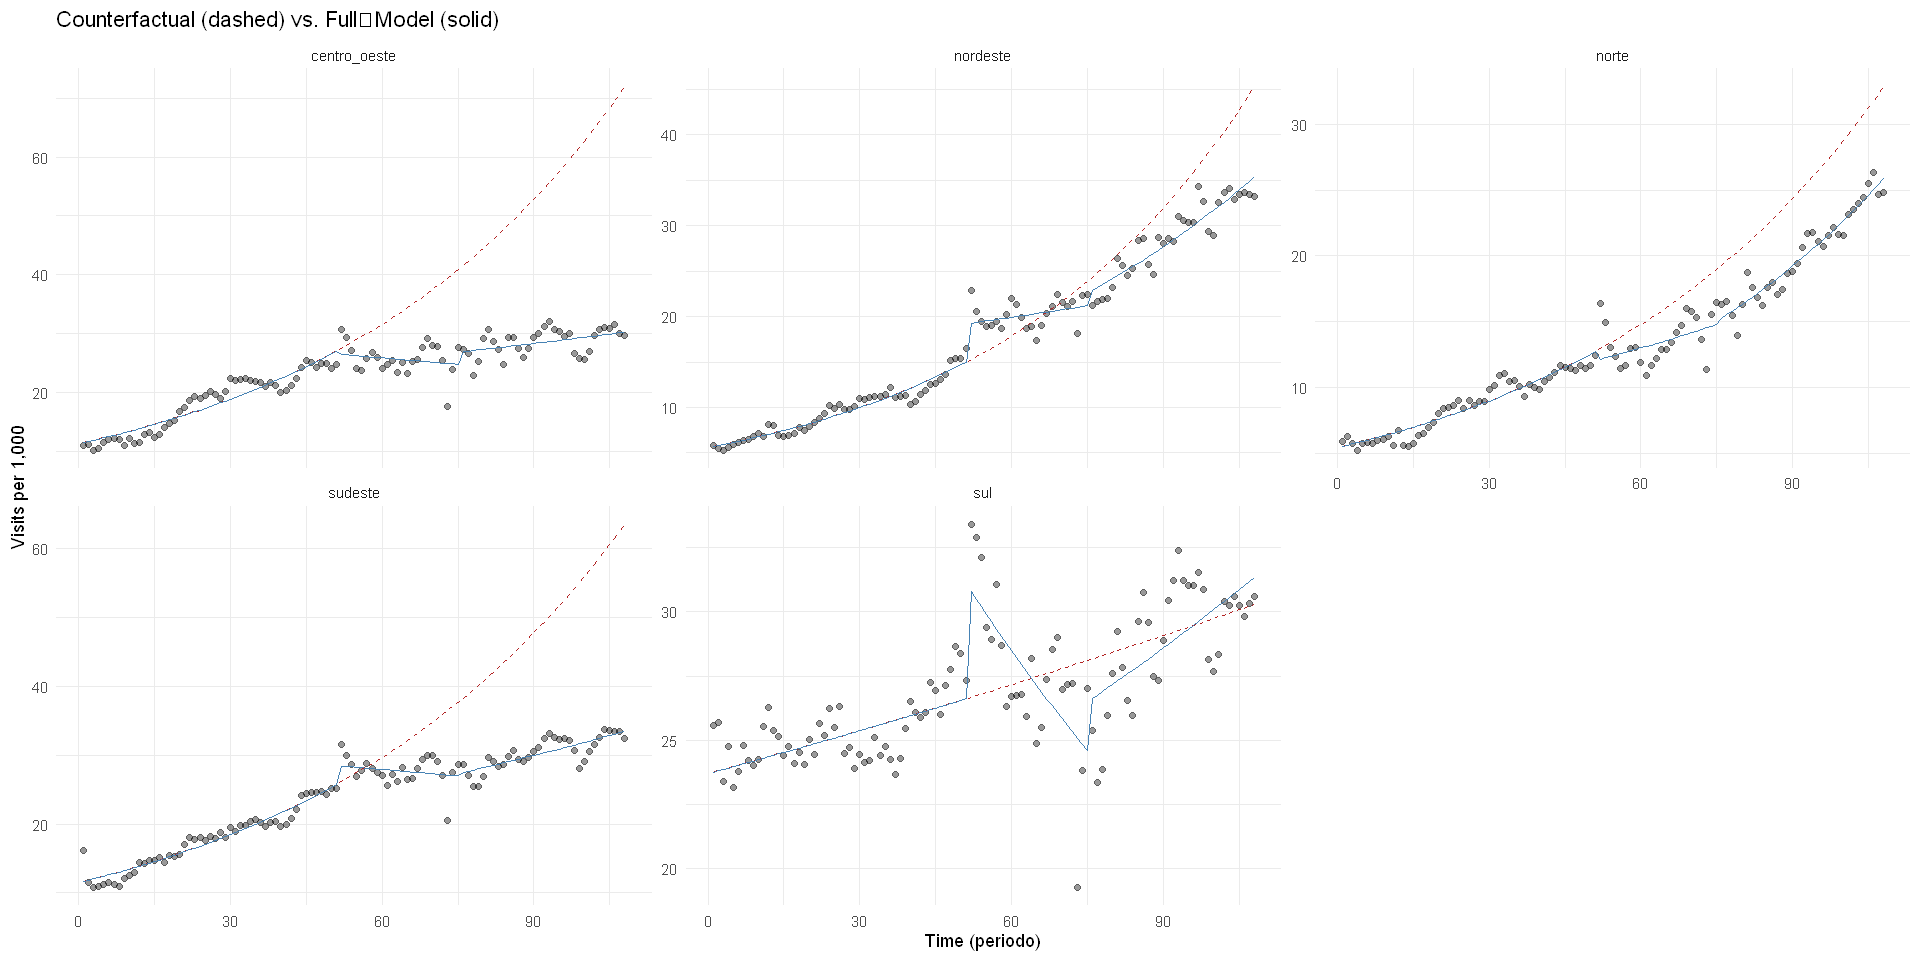

In [35]:
get_predictions <- function(region_data) {
  # 1) Fit the full model once
  full_model <- glm(
    mental_health_visits ~ periodo +
      Pandemia_Step + Pandemia_Trend +
      PosPandemia_Step + PosPandemia_Trend,
    family = poisson(),
    data = region_data,
    offset = log(total_visits / 1000)
  )

  # 2) Build two newdata sets:
  #    a) baseline (all dummies = 0)   → counterfactual
  #    b) full     (as‐is)             → fitted
  newdata_baseline <- region_data %>%
    mutate(
      Pandemia_Step      = 0,
      Pandemia_Trend     = 0,
      PosPandemia_Step   = 0,
      PosPandemia_Trend  = 0
    )

  # 3) Predict
  region_data %>%
    mutate(
      baseline_pred = predict(full_model,
        newdata = newdata_baseline,
        type    = "response"
      ),
      full_pred = predict(full_model, type = "response"),
      # if you want rates per 1,000
      rate_obs = mental_health_visits / (total_visits / 1000),
      rate_base = baseline_pred / (total_visits / 1000),
      rate_full = full_pred / (total_visits / 1000)
    )
}

plot_data <- regression_df %>%
  group_by(regiao) %>%
  group_modify(~ get_predictions(.x)) %>%
  ungroup()

ggplot(plot_data, aes(x = periodo)) +
  geom_point(aes(y = rate_obs), alpha = 0.4) +
  geom_line(aes(y = rate_base), linetype = "dashed", color = "firebrick") +
  geom_line(aes(y = rate_full), color = "steelblue") +
  facet_wrap(~regiao, scales = "free_y") +
  labs(
    title = "Counterfactual (dashed) vs. Full‐Model (solid)",
    x     = "Time (periodo)",
    y     = "Visits per 1,000"
  ) +
  theme_minimal()


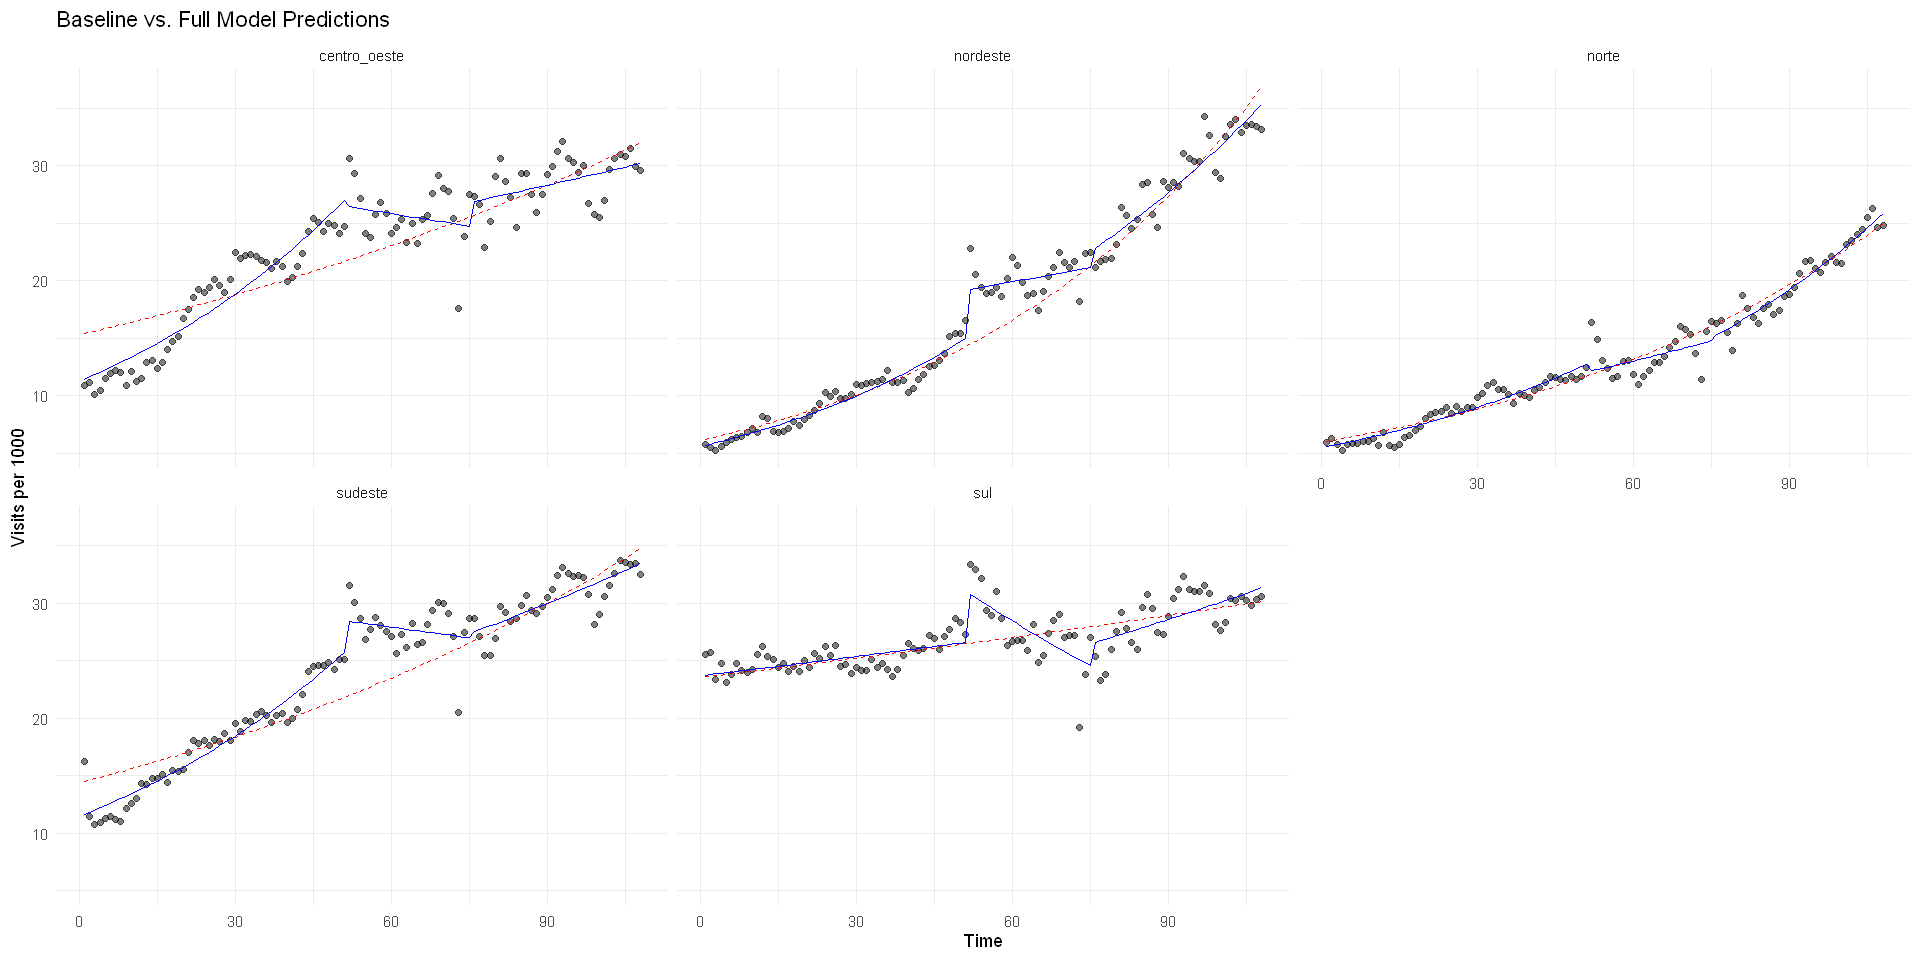

In [15]:
library(dplyr)
library(purrr)
library(ggplot2)

# 1. First, create a function that calculates predictions for one region
get_predictions <- function(region_data) {
  # Fit baseline model (pre-pandemic only)
  baseline_model <- glm(
    mental_health_visits ~ periodo,
    family = poisson(),
    data = filter(region_data, Pandemia_Step == 0),
    offset = log(total_visits / 1000)
  )

  # Fit full model
  full_model <- glm(
    mental_health_visits ~ periodo + Pandemia_Step + Pandemia_Trend +
      PosPandemia_Step + PosPandemia_Trend,
    family = poisson(),
    data = region_data,
    offset = log(total_visits / 1000)
  )

  # Add predictions
  region_data %>%
    mutate(
      baseline_pred = predict(baseline_model, newdata = ., type = "response"),
      full_pred = predict(full_model, type = "response"),
      rate_observed = mental_health_visits / (total_visits / 1000),
      rate_baseline = baseline_pred / (total_visits / 1000),
      rate_full = full_pred / (total_visits / 1000)
    )
}

# 2. Apply to all regions
plot_data <- regression_df %>%
  group_by(regiao) %>%
  group_modify(~ get_predictions(.x)) %>%
  ungroup()

# 3. Plot the results
ggplot(plot_data, aes(x = periodo)) +
  geom_point(aes(y = rate_observed), alpha = 0.5) +
  geom_line(aes(y = rate_baseline), color = "#ff0000", linetype = "dashed") +
  geom_line(aes(y = rate_full), color = "blue") +
  facet_wrap(~regiao) +
  labs(
    title = "Baseline vs. Full Model Predictions",
    y = "Visits per 1000",
    x = "Time"
  ) +
  theme_minimal()


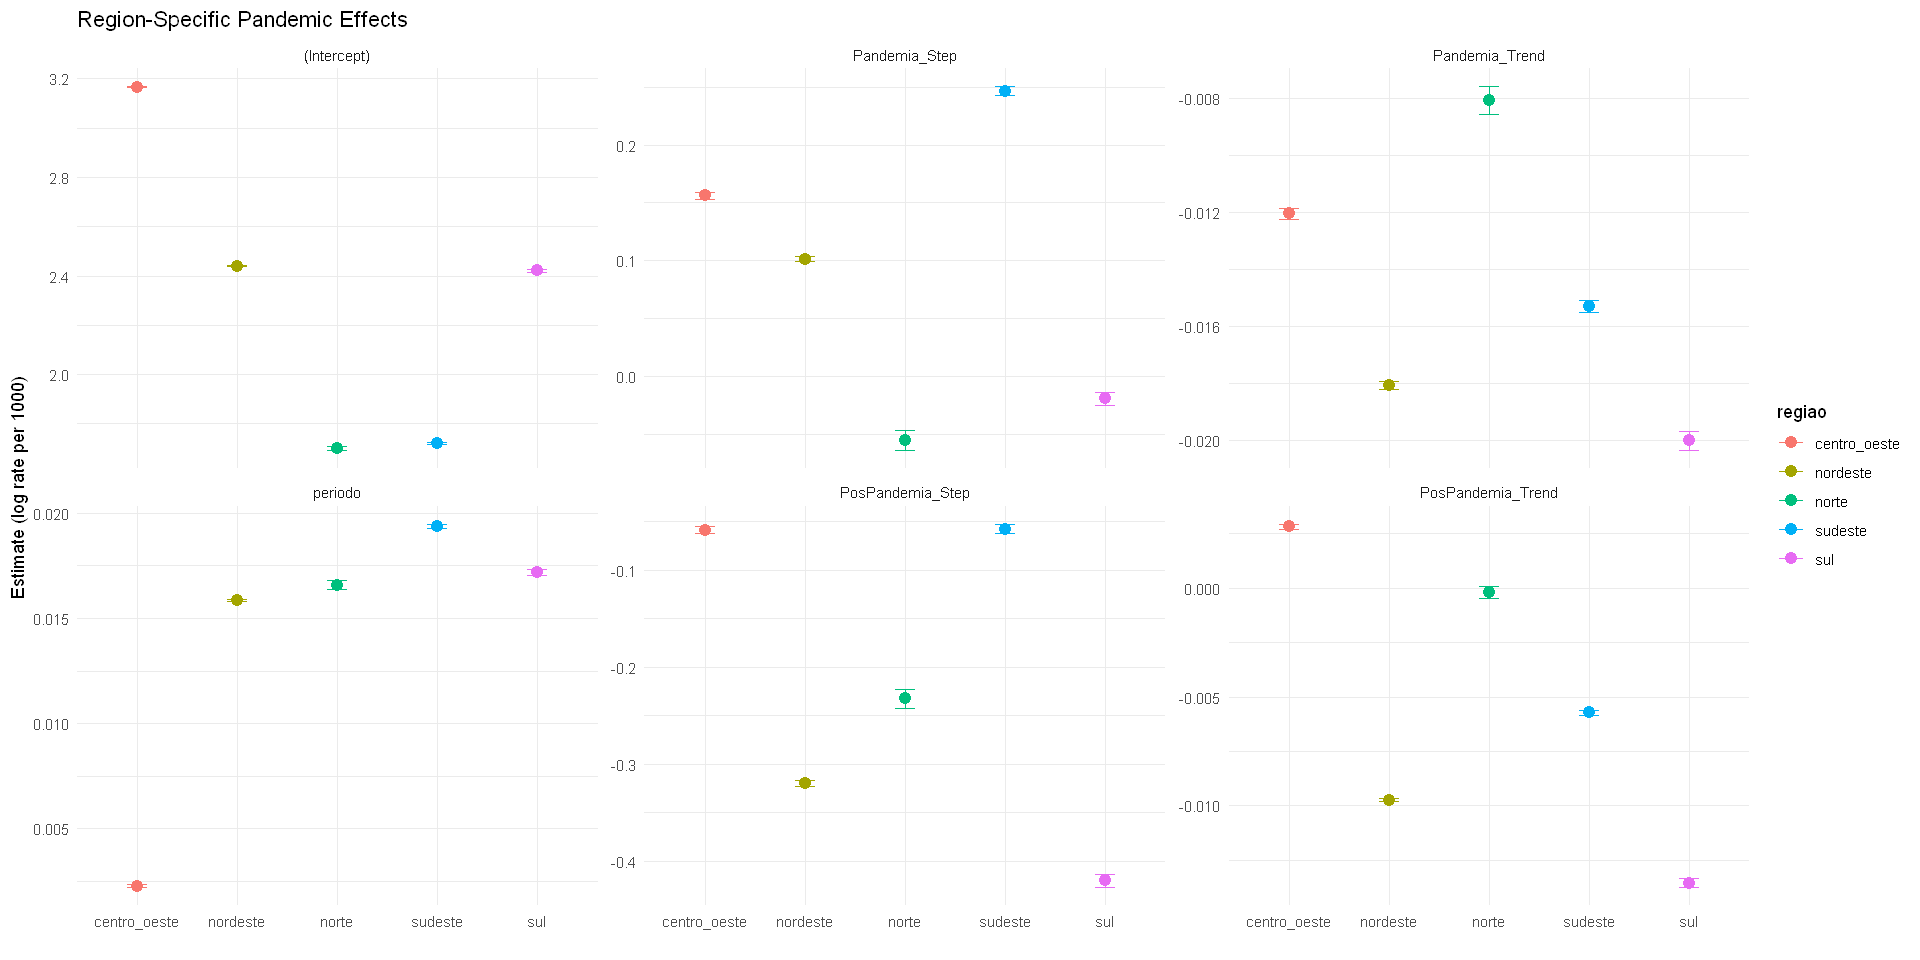

In [ ]:
ggplot(region_results, aes(x = regiao, y = estimate, color = regiao)) +
     geom_point(size = 3) +
     geom_errorbar(
          aes(
               ymin = estimate - 1.96 * std.error,
               ymax = estimate + 1.96 * std.error
          ),
          width = 0.2
     ) +
     facet_wrap(~term, scales = "free_y") +
     labs(
          title = "Region-Specific Pandemic Effects",
          y = "Estimate (log rate per 1000)", x = ""
     ) +
     theme_minimal()


# Diagnostics

In [36]:
# 1) Nest + fit one model per region
models_df <- regression_df %>%
    group_by(regiao) %>%
    group_nest() %>%
    mutate(
        model = map(data, ~ glm(
            mental_health_visits ~ periodo +
                Pandemia_Step + Pandemia_Trend +
                PosPandemia_Step + PosPandemia_Trend,
            family = poisson(),
            offset = log(total_visits / 1000),
            data = .
        ))
    )

# 2) Compute dispersion & glance statistics (note: AIC is uppercase)
diag_stats <- models_df %>%
    transmute(
        regiao,
        # pearson dispersion = sum(pearson res^2) / df.resid
        pearson_disp = map_dbl(model, ~ sum(residuals(.x, type = "pearson")^2) / df.residual(.x)),
        deviance_disp = map_dbl(model, ~ deviance(.x) / df.residual(.x)),
        glance = map(model, broom::glance)
    ) %>%
    unnest_wider(glance) %>%
    select(
        regiao,
        pearson_disp,
        deviance_disp,
        AIC, # uppercase in glance()
        deviance,
        df.residual
    ) %>%
    # optional: rename AIC → aic
    rename(aic = AIC)

diag_stats


regiao,pearson_disp,deviance_disp,aic,deviance,df.residual
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
centro_oeste,289.8816,294.7346,31390.14,30062.92,102
nordeste,426.3500,426.8498,44965.74,43538.68,102
norte,104.0671,103.6647,11827.96,10573.80,102
sudeste,780.3826,792.1815,82319.40,80802.52,102
sul,449.8394,455.3160,47907.24,46442.23,102


In [ ]:
diagnose(model)


ERROR: Error: objeto 'model' não encontrado


In [ ]:
# Check convergence
summary(model)$convergence # Should be TRUE

# Inspect random effects
ranef(model)$cond$regiao %>% head()

# Check for singularity
performance::check_singularity(model)


NULL

,(Intercept)
,<dbl>
centro_oeste,0.1325172
nordeste,-0.1946759
norte,-0.4602858
sudeste,0.1639269
sul,0.3577302


[1] FALSE

Some of the focal terms are of type `character`. This may lead to
  unexpected results. It is recommended to convert these variables to
  factors before fitting the model.
  The following variables are of type character: `regiao`

Model uses a transformed offset term. Predictions may not be correct.
  It is recommended to fix the offset term using the `condition` argument,
  e.g. `condition = c(total_visits = 1)`.
  You could also transform the offset variable before fitting the model
  and use `offset(total_visits)` in the model formula.



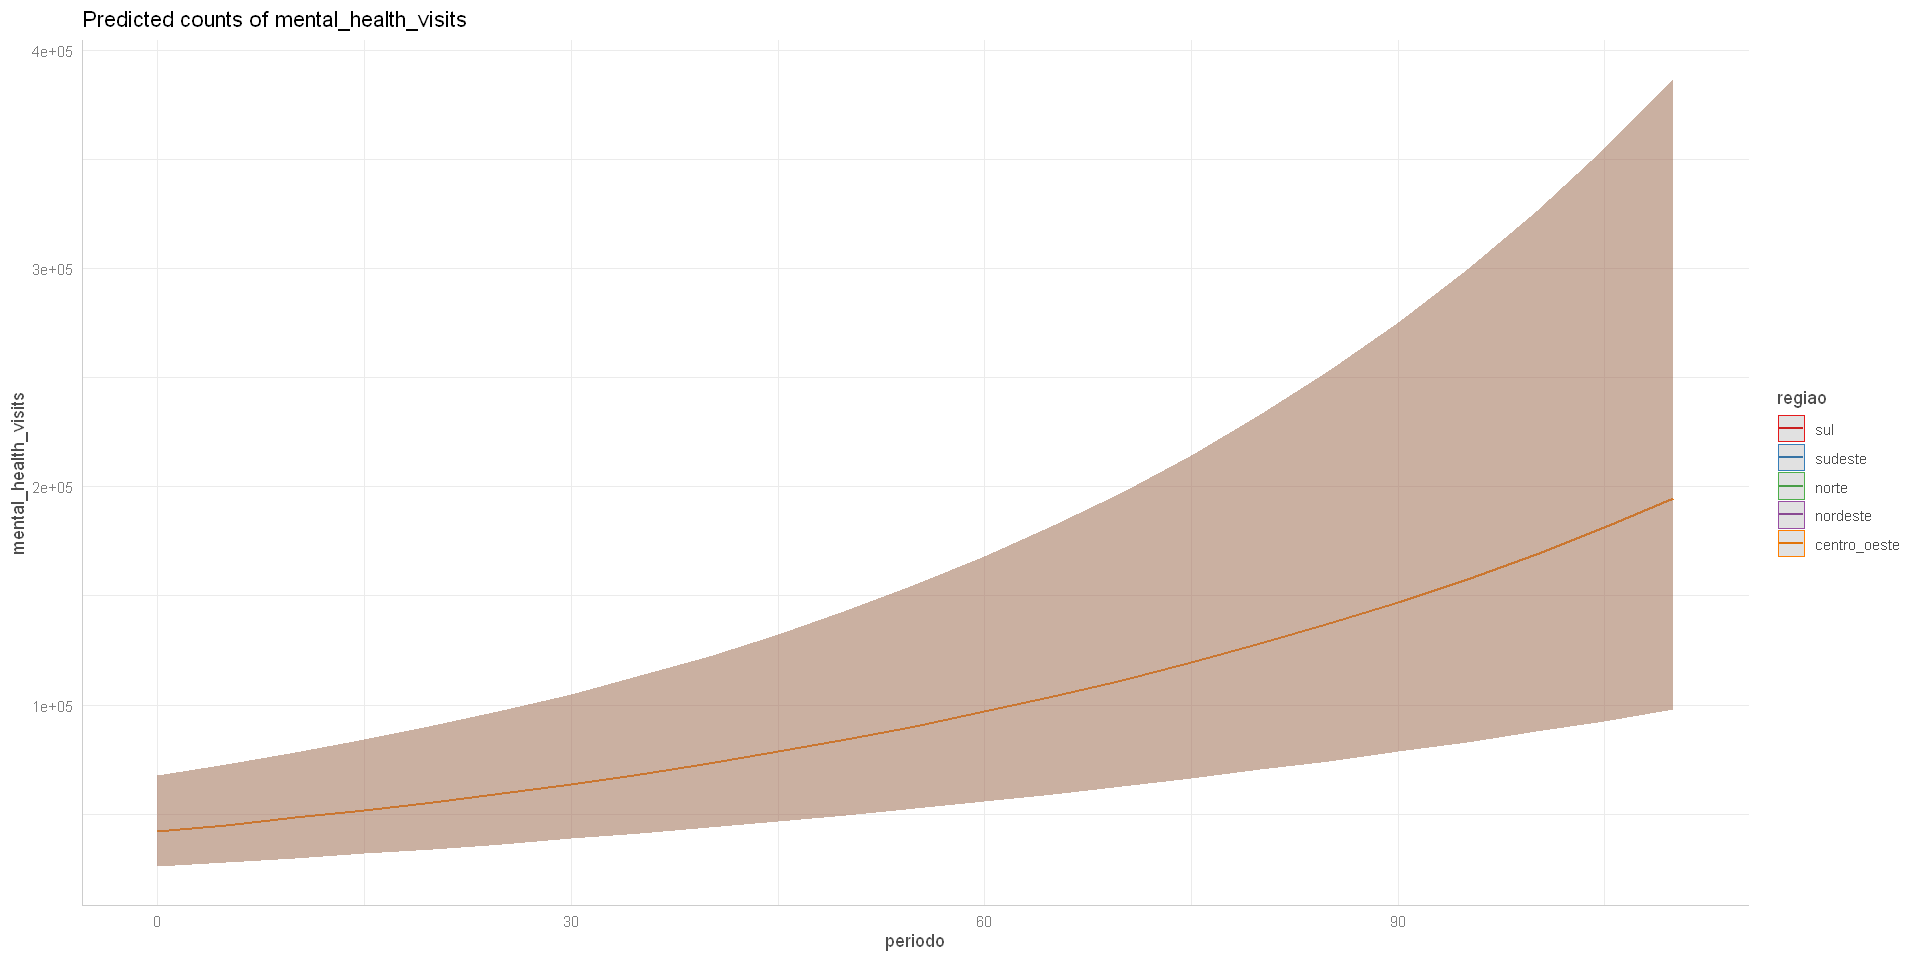

In [ ]:
plot(ggpredict(model, terms = c("periodo", "regiao")))


In [ ]:
# Check convergence (should be TRUE)
model$fit$convergence == 0

# View optimization details
model$fit$message


[1] TRUE

[1] "relative convergence (4)"

DHARMa:testOutliers with type = binomial may have inflated Type I error rates for integer-valued distributions. To get a more exact result, it is recommended to re-run testOutliers with type = 'bootstrap'. See ?testOutliers for details



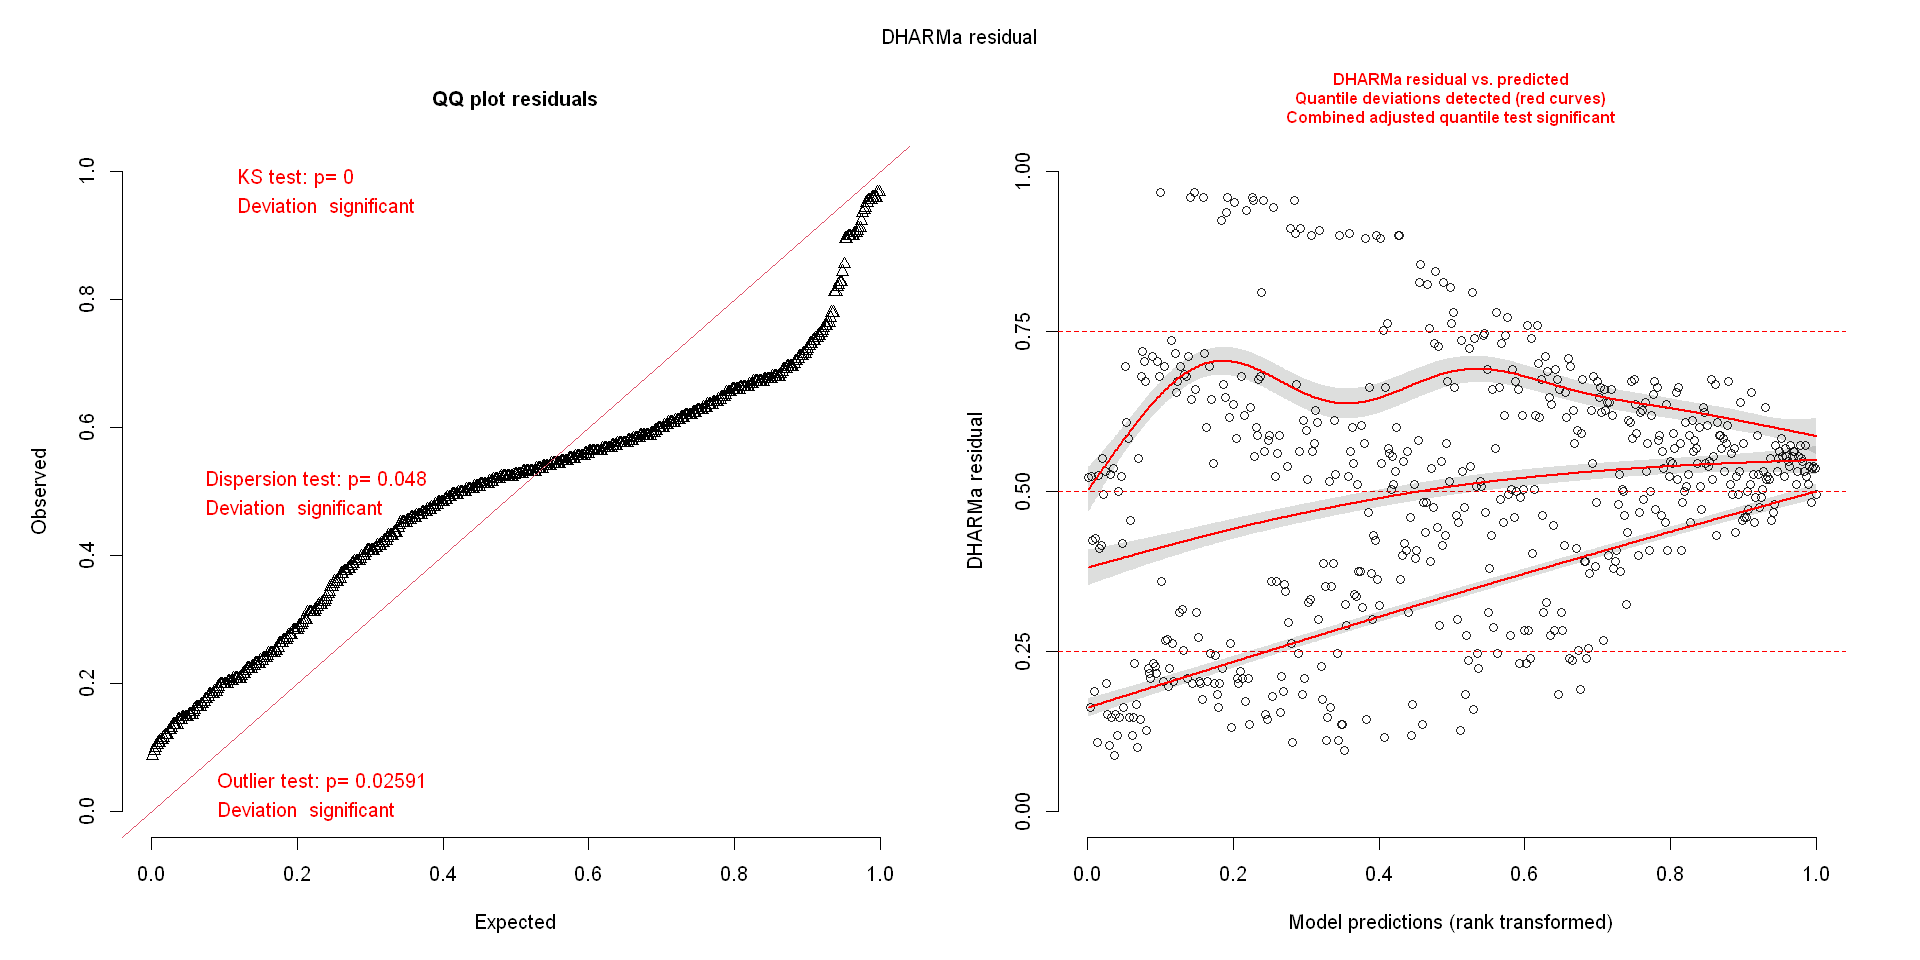

In [ ]:
# Residuals Diagnostics
sim_res <- simulateResiduals(model, plot = TRUE)


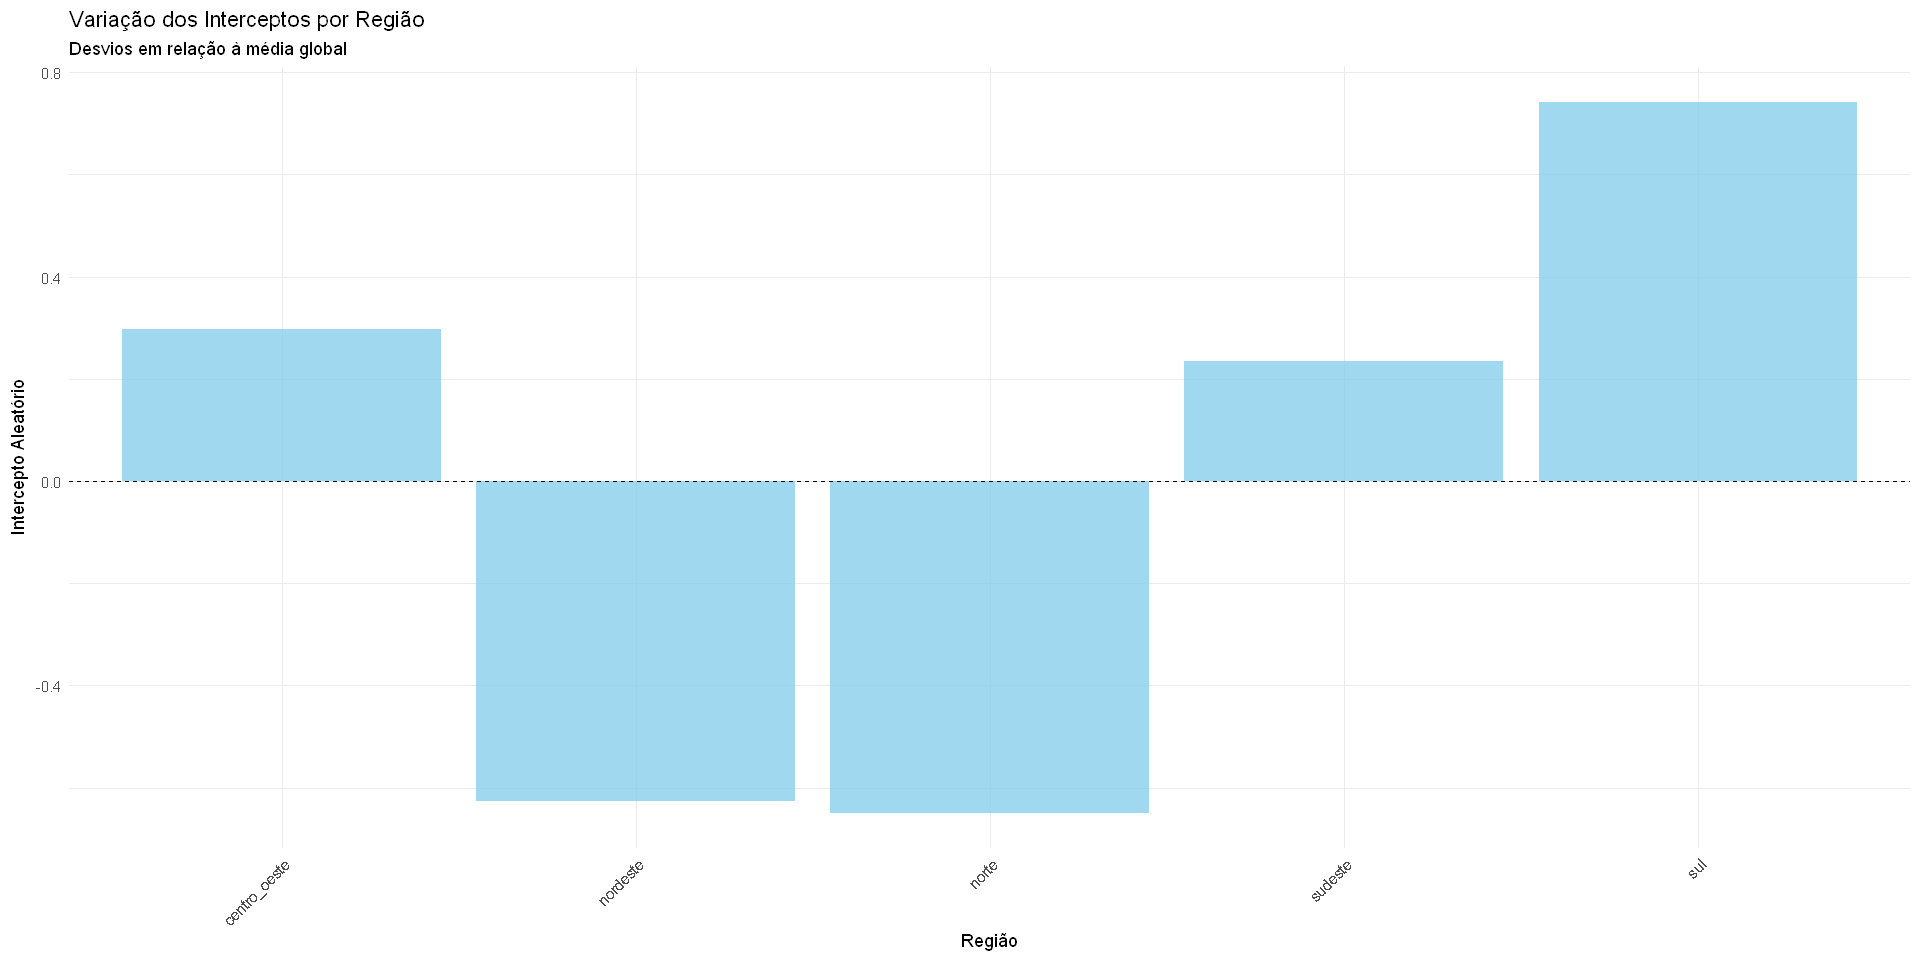

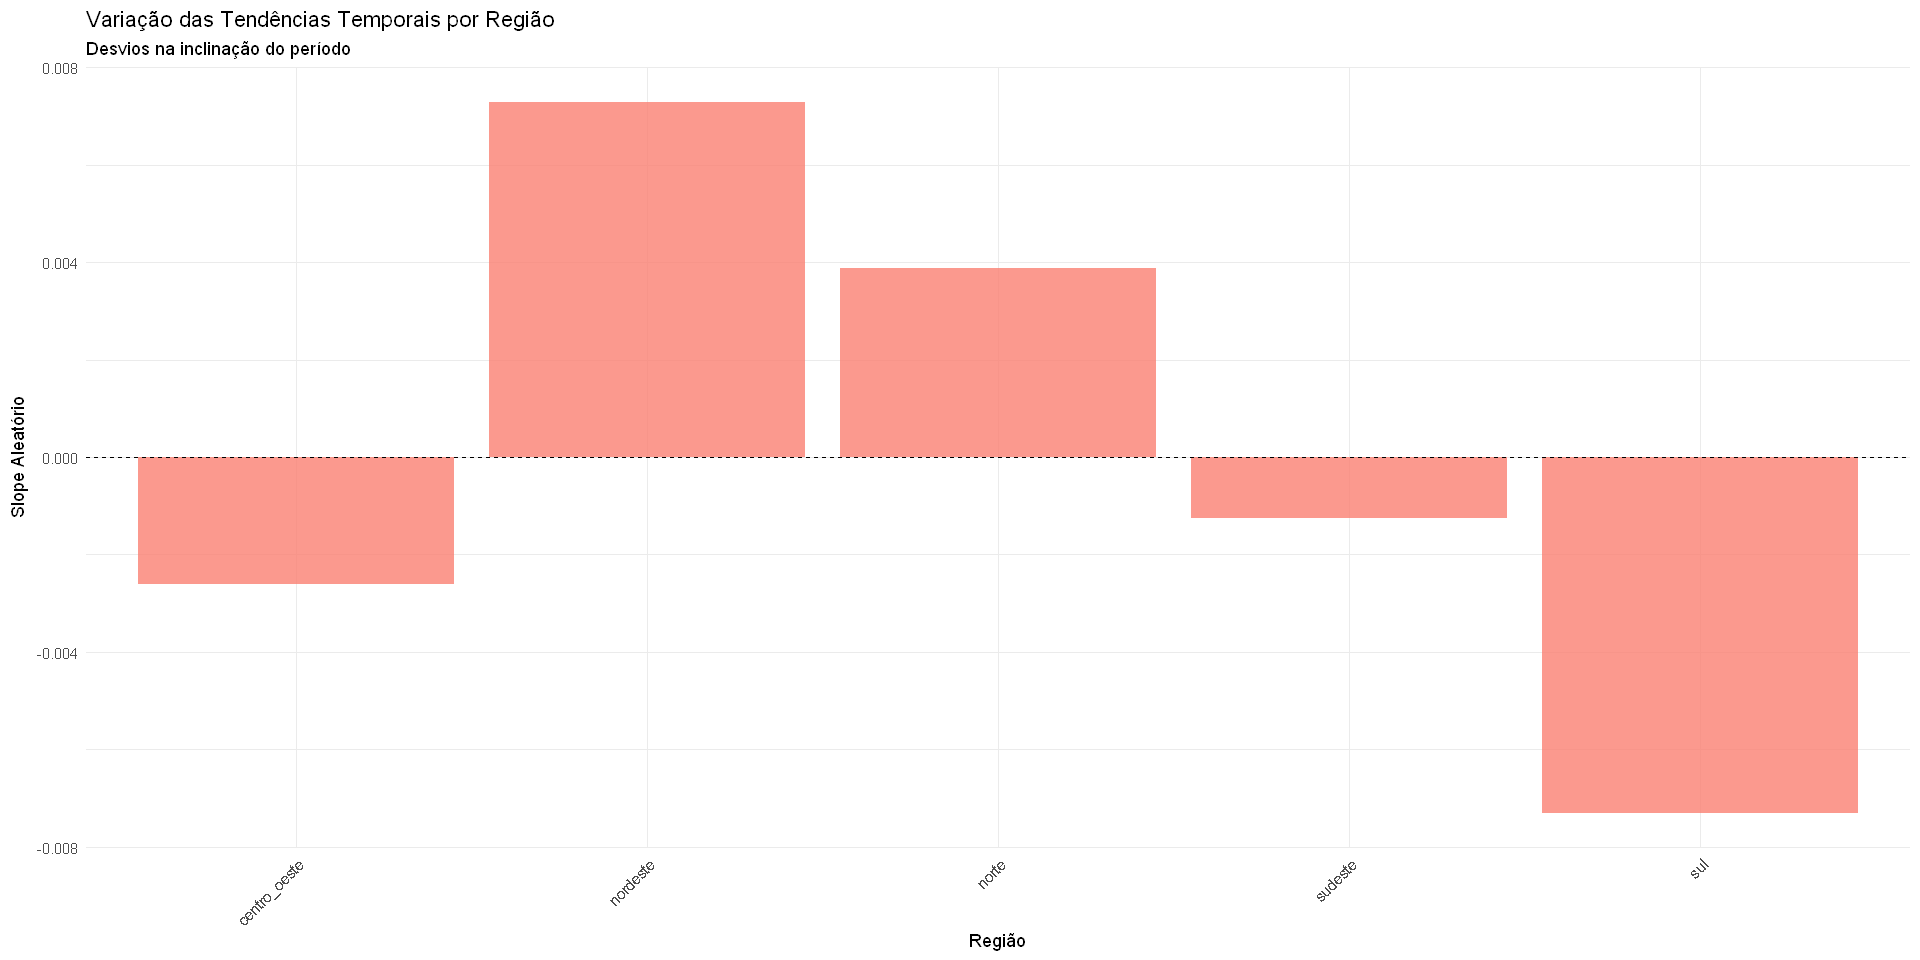

In [ ]:
# 3. Random Effects Distribution

# 1. Extrair efeitos aleatórios corretamente
ranefs <- ranef(model)$cond$regiao

# 2. Converter para dataframe para facilitar o plot
ranef_df <- data.frame(
  Region = rownames(ranefs),
  Intercept = ranefs[, 1]
)

# 3. Plot dos interceptos aleatórios
plot_intercepts <- ggplot(ranef_df, aes(x = Region, y = Intercept)) +
  geom_col(fill = "skyblue", alpha = 0.8) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(
    title = "Variação dos Interceptos por Região",
    subtitle = "Desvios em relação à média global",
    y = "Intercepto Aleatório",
    x = "Região"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

print(plot_intercepts)

# 4. Verificar e plotar slopes aleatórios (se existirem)
if ("periodo" %in% colnames(ranefs)) {
  ranef_df$Slope <- ranefs[, "periodo"]

  plot_slopes <- ggplot(ranef_df, aes(x = Region, y = Slope)) +
    geom_col(fill = "salmon", alpha = 0.8) +
    geom_hline(yintercept = 0, linetype = "dashed") +
    labs(
      title = "Variação das Tendências Temporais por Região",
      subtitle = "Desvios na inclinação do período",
      y = "Slope Aleatório",
      x = "Região"
    ) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

  print(plot_slopes)
} else {
  message("O modelo não inclui slopes aleatórios para 'periodo'")
}


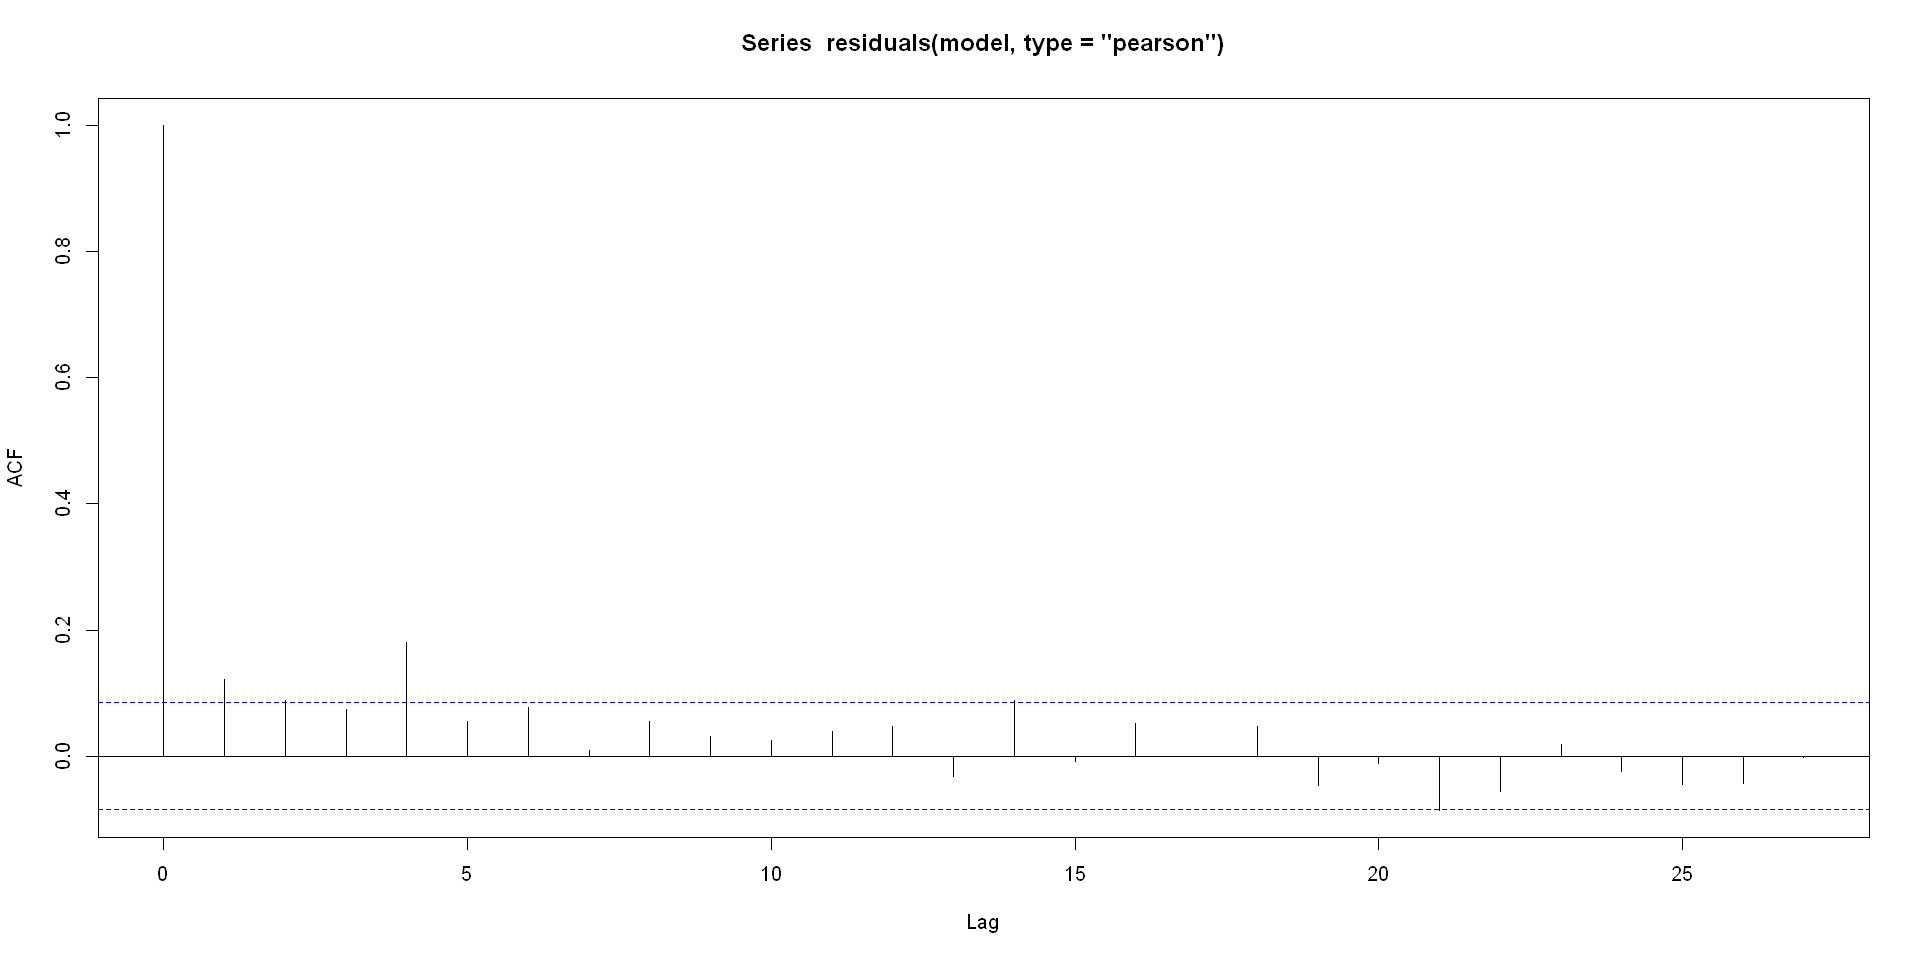

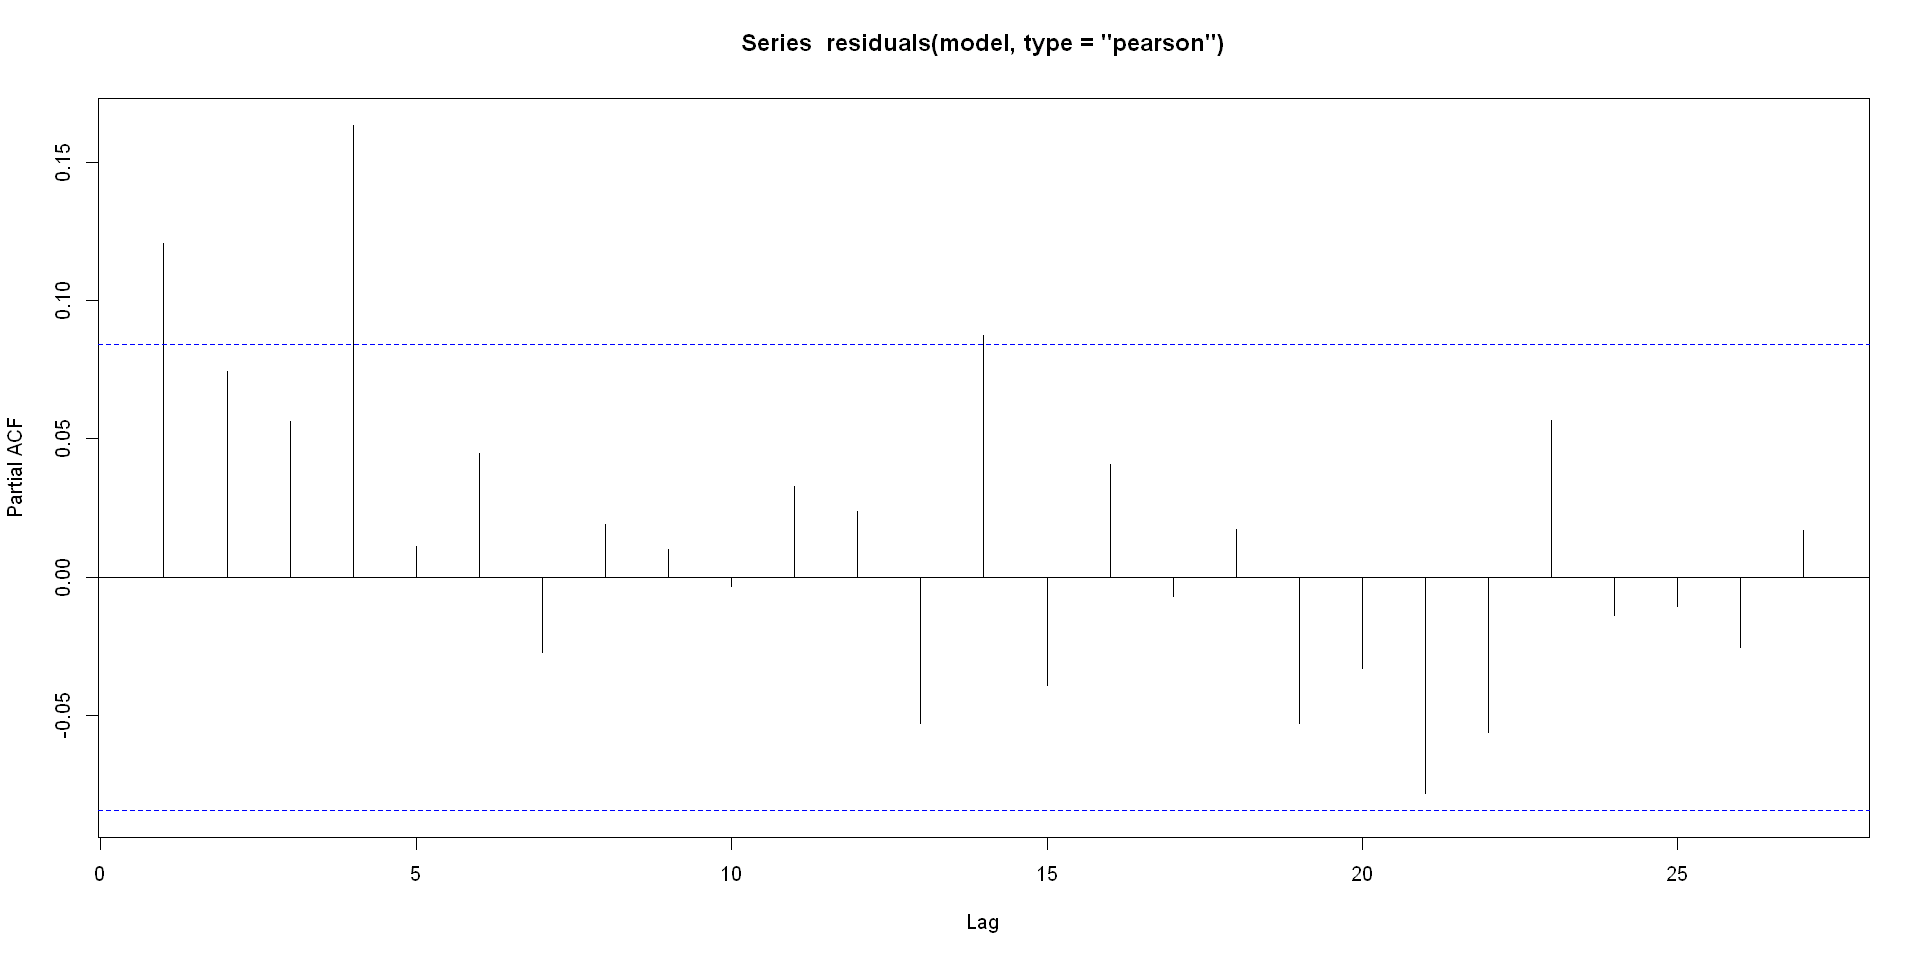

In [ ]:
# Plot ACF/PACF of residuals
acf(residuals(model, type = "pearson"))
pacf(residuals(model, type = "pearson"))



	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
dispersion = 0.024714, p-value < 2.2e-16
alternative hypothesis: two.sided


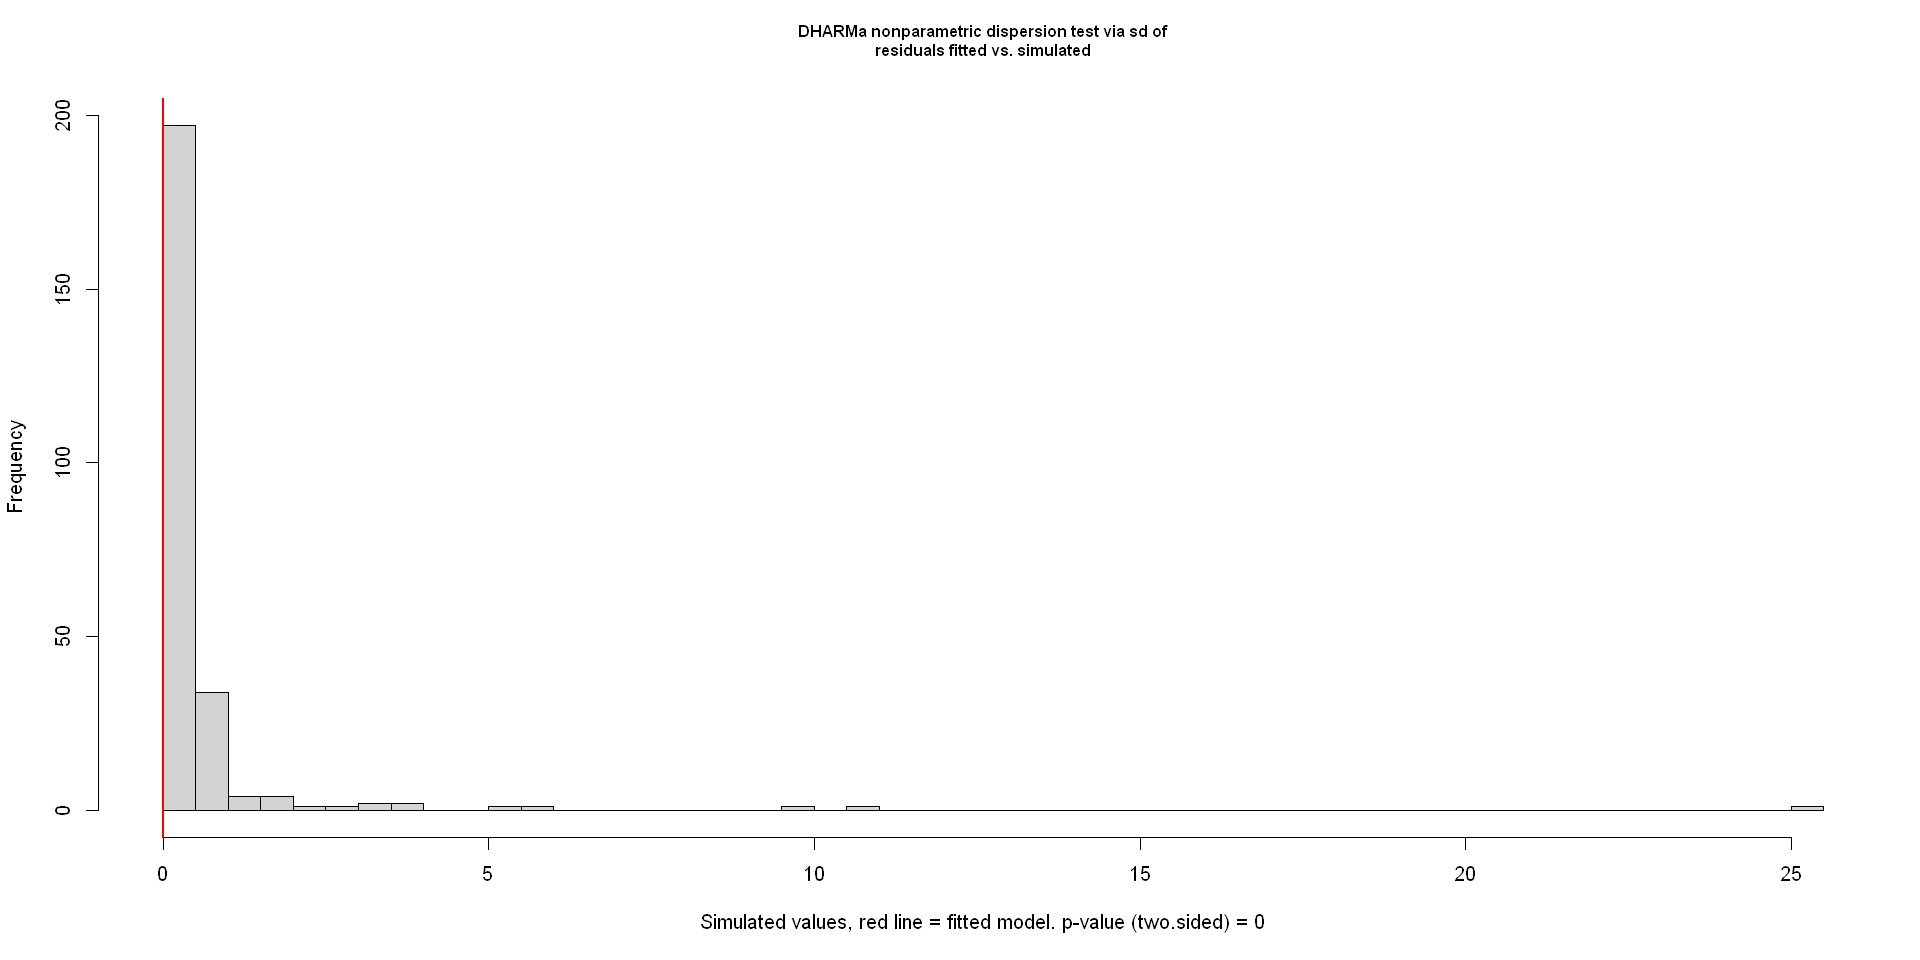

In [ ]:
# Overdispersion Test
testDispersion(sim_res)
# Ratio should be close to 1


Some of the focal terms are of type `character`. This may lead to
  unexpected results. It is recommended to convert these variables to
  factors before fitting the model.
  The following variables are of type character: `regiao`

Model uses a transformed offset term. Predictions may not be correct.
  It is recommended to fix the offset term using the `condition` argument,
  e.g. `condition = c(total_visits = 1)`.
  You could also transform the offset variable before fitting the model
  and use `offset(total_visits)` in the model formula.



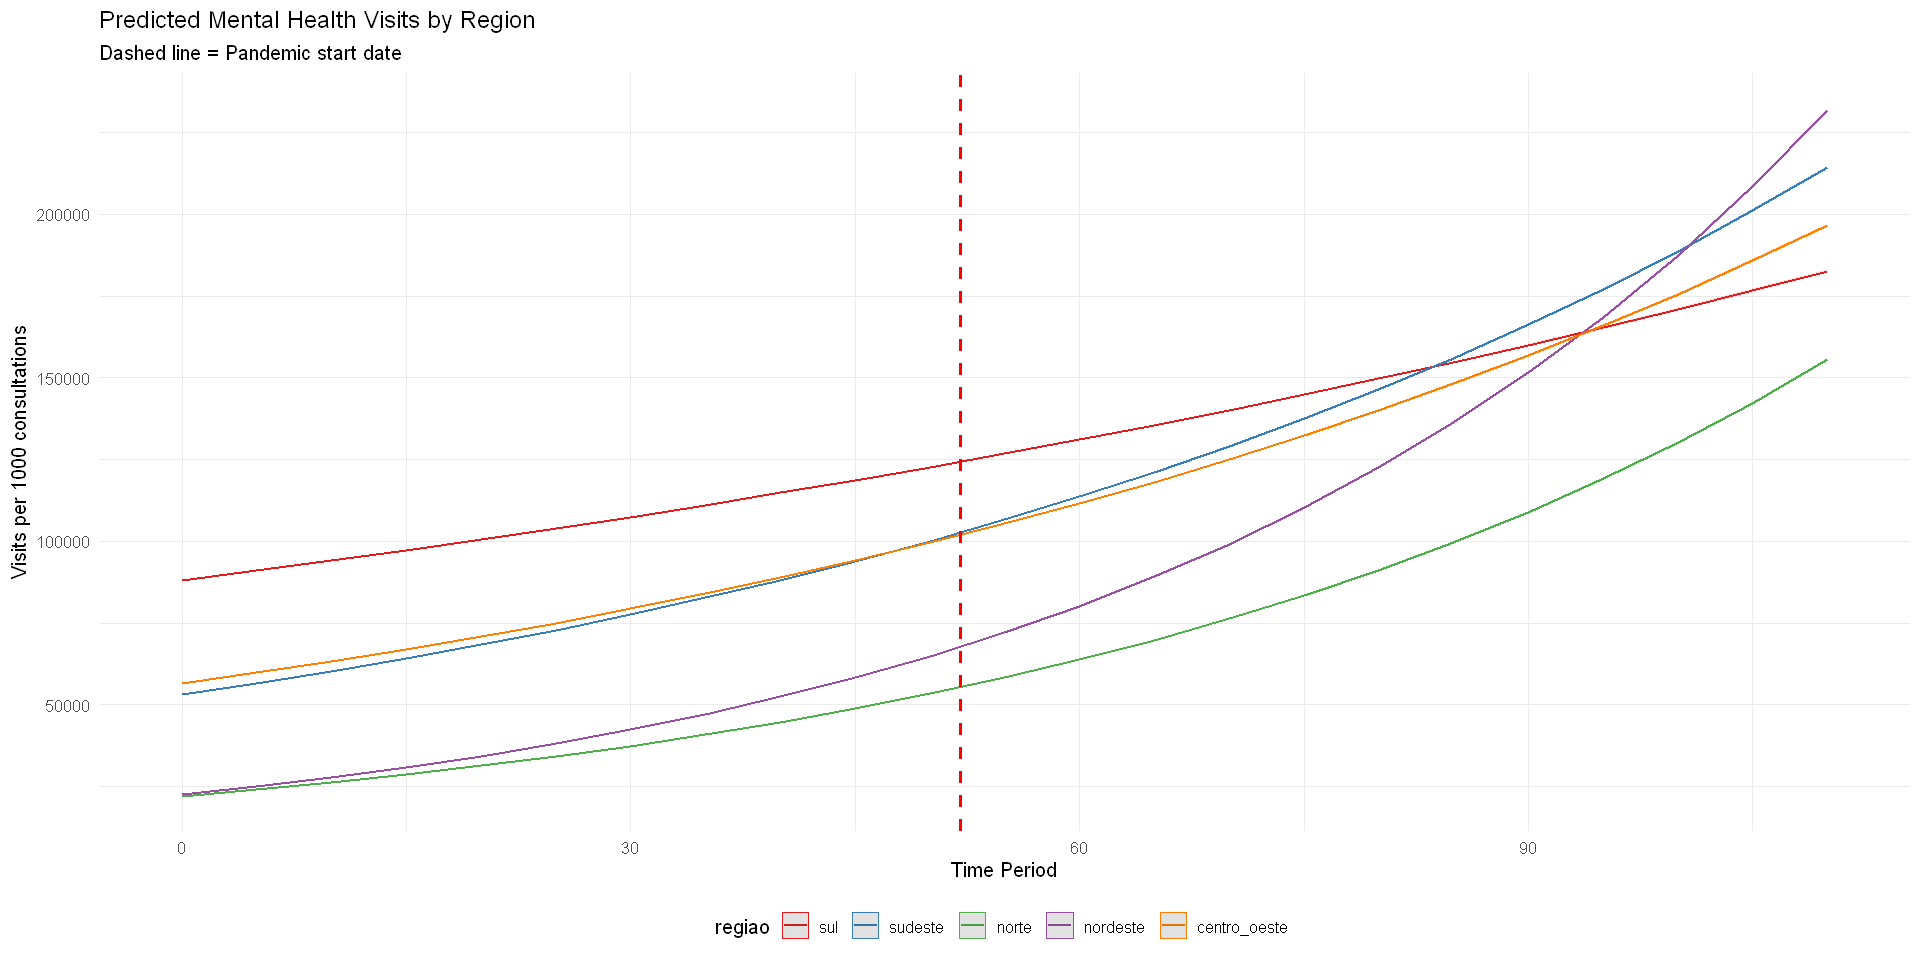

In [ ]:
# Fixed Effects Visualization

# Generate predictions
preds <- ggpredict(model,
  terms = c("periodo", "regiao"), # Vary periodo by region
  type = "random"
) # Include random effects

# Plot with pandemic marker
fixed_plot <- plot(preds) +
  geom_vline(
    xintercept = pandemic_start_date,
    linetype = "dashed",
    color = "red",
    linewidth = 1
  ) +
  labs(
    title = "Predicted Mental Health Visits by Region",
    subtitle = "Dashed line = Pandemic start date",
    y = "Visits per 1000 consultations",
    x = "Time Period"
  ) +
  theme_minimal(base_size = 12) +
  theme(legend.position = "bottom")

print(fixed_plot)


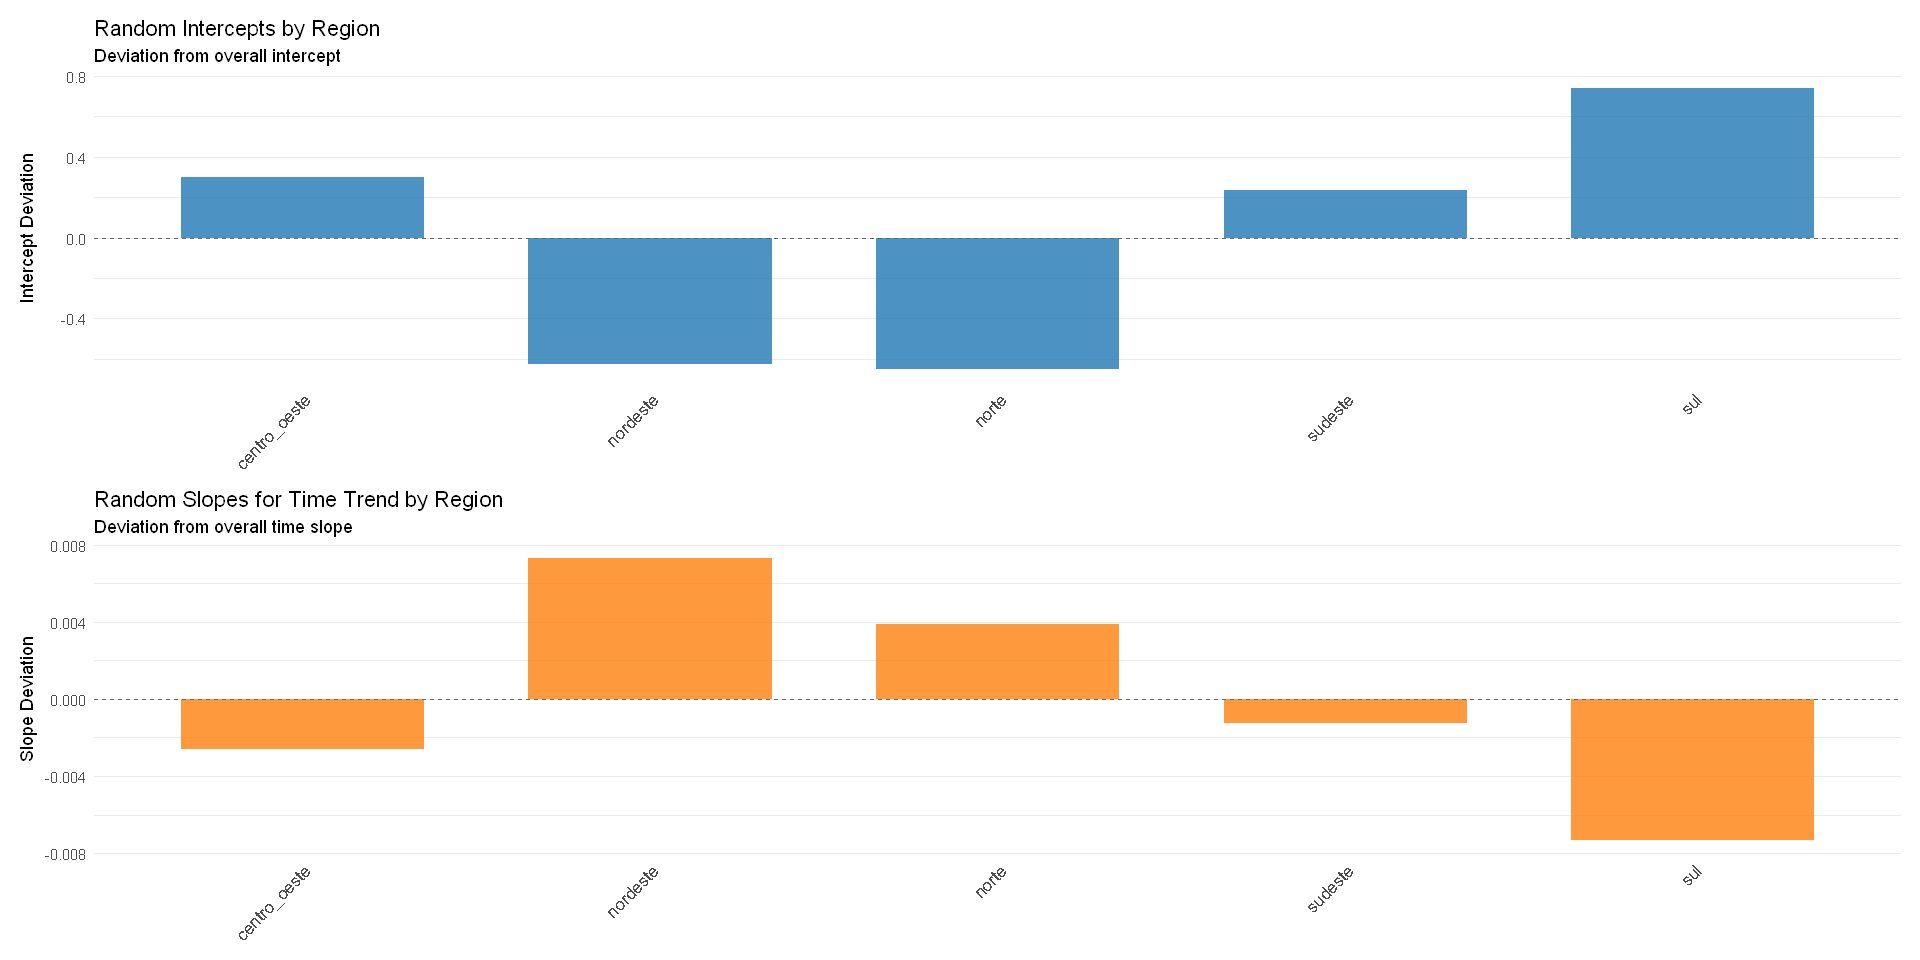

In [ ]:
# Extract random effects safely
ranefs <- ranef(model)$cond$regiao

# Convert to dataframe
ranef_df <- as.data.frame(ranefs)
ranef_df$Region <- rownames(ranefs)

# 1. Plot Random Intercepts
intercept_plot <- ggplot(ranef_df, aes(x = Region, y = `(Intercept)`)) +
  geom_col(fill = "#1f77b4", alpha = 0.8, width = 0.7) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "gray40") +
  labs(
    title = "Random Intercepts by Region",
    subtitle = "Deviation from overall intercept",
    y = "Intercept Deviation",
    x = NULL
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    panel.grid.major.x = element_blank()
  )

# 2. Plot Random Slopes (if they exist)
if ("periodo" %in% names(ranef_df)) {
  slope_plot <- ggplot(ranef_df, aes(x = Region, y = periodo)) +
    geom_col(fill = "#ff7f0e", alpha = 0.8, width = 0.7) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "gray40") +
    labs(
      title = "Random Slopes for Time Trend by Region",
      subtitle = "Deviation from overall time slope",
      y = "Slope Deviation",
      x = NULL
    ) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
      panel.grid.major.x = element_blank()
    )

  # Display both plots
  library(patchwork)
  combined_plots <- intercept_plot + slope_plot + plot_layout(ncol = 1)
  print(combined_plots)
} else {
  print(intercept_plot)
  message("\nNote: No random slopes for 'periodo' in the model")
}


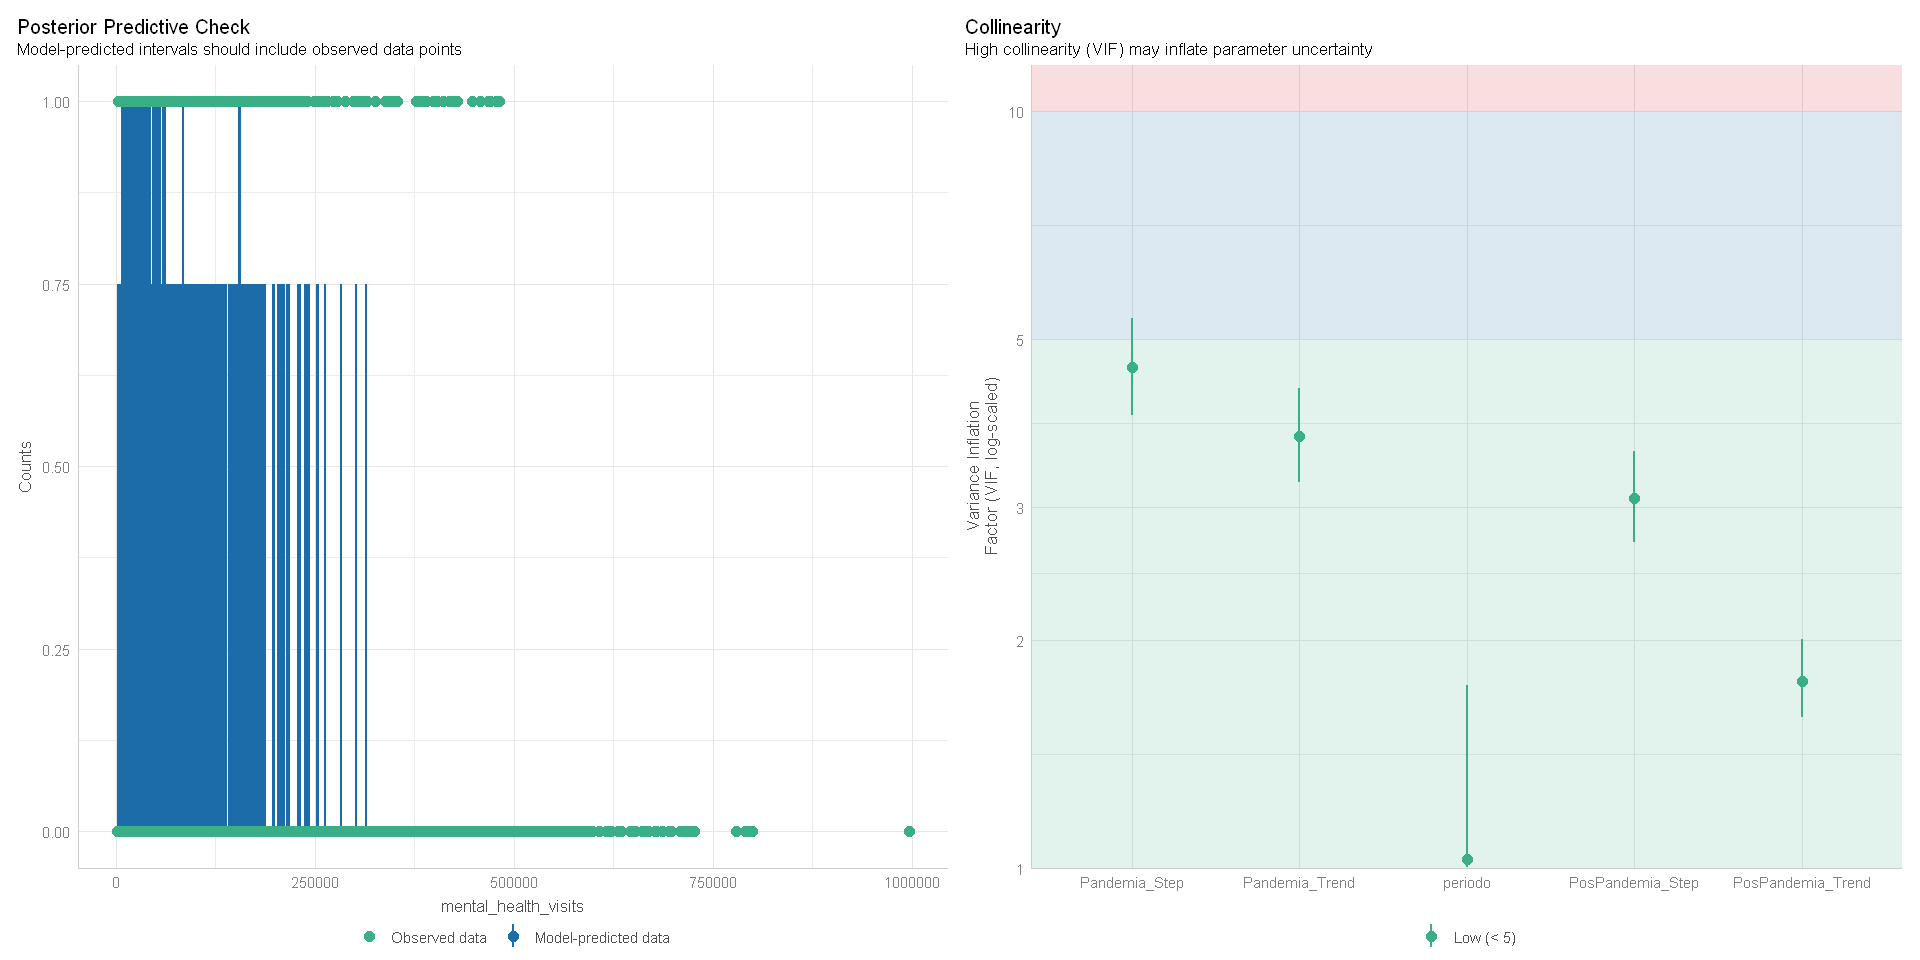

In [ ]:
# Influence Diagnostics (aparentemente DHARMa test residuals é mais adequado para este modelo (glmmTMB))
# check_model(model,
#           check = c("vif", "pp_check", "binned_residuals"),
#           residual_type = "normal")  # Critical for glmmTMB


In [ ]:
# Effect Sizes
# Get rate ratios for pandemic effect
emmeans(model, ~Pandemia_Step, type = "response")


 Pandemia_Step response       SE  df asymp.LCL asymp.UCL
             0 2.35e+08 64100000 Inf  1.38e+08  4.01e+08
             1 2.58e+08 70900000 Inf  1.51e+08  4.42e+08

Results are averaged over the levels of: PosPandemia_Step 
Confidence level used: 0.95 
Intervals are back-transformed from the log scale 

In [ ]:
# Check if fixed model is better
# Fit a model WITHOUT random slopes for pandemic
model_fixed <- update(model, . ~ . - (1 + periodo | regiao) + (1 | regiao))

# Likelihood Ratio Test
anova(model, model_fixed)


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
model,10,268353.4,268396.3,-134166.7,268333.4,NA,NA,NA
model_fixed,10,268353.4,268396.3,-134166.7,268333.4,0,0,1


# Region Coefficients

In [ ]:
# Get ALL fixed effects with CIs
all_coefs <- tidy(model,
  conf.int = TRUE,
  effects = "fixed"
) %>% # Extract fixed effects only
  mutate( # Exponentiate if using log/logit link
    estimate = exp(estimate), # Remove if not needed
    conf.low = exp(conf.low),
    conf.high = exp(conf.high)
  )

# Filter for regions and pandemic dummies
key_coefs <- all_coefs %>%
  filter(grepl("regiao", term, ignore.case = TRUE) |
    grepl(paste(DUMMIES_LIST, collapse = "|"), term, ignore.case = TRUE))

print(key_coefs, n = Inf) # Show all rows


# A tibble: 4 × 9
  effect component term           estimate std.error statistic  p.value conf.low
  <chr>  <chr>     <chr>             <dbl>     <dbl>     <dbl>    <dbl>    <dbl>
1 fixed  cond      Pandemia_Step     1.10  0.0419         2.18 2.94e- 2    1.01 
2 fixed  cond      Pandemia_Trend    0.986 0.00122      -11.8  5.58e-32    0.983
3 fixed  cond      PosPandemia_S…    0.824 0.00100     -193.   0           0.823
4 fixed  cond      PosPandemia_T…    0.994 0.0000283   -196.   0           0.994
# ℹ 1 more variable: conf.high <dbl>


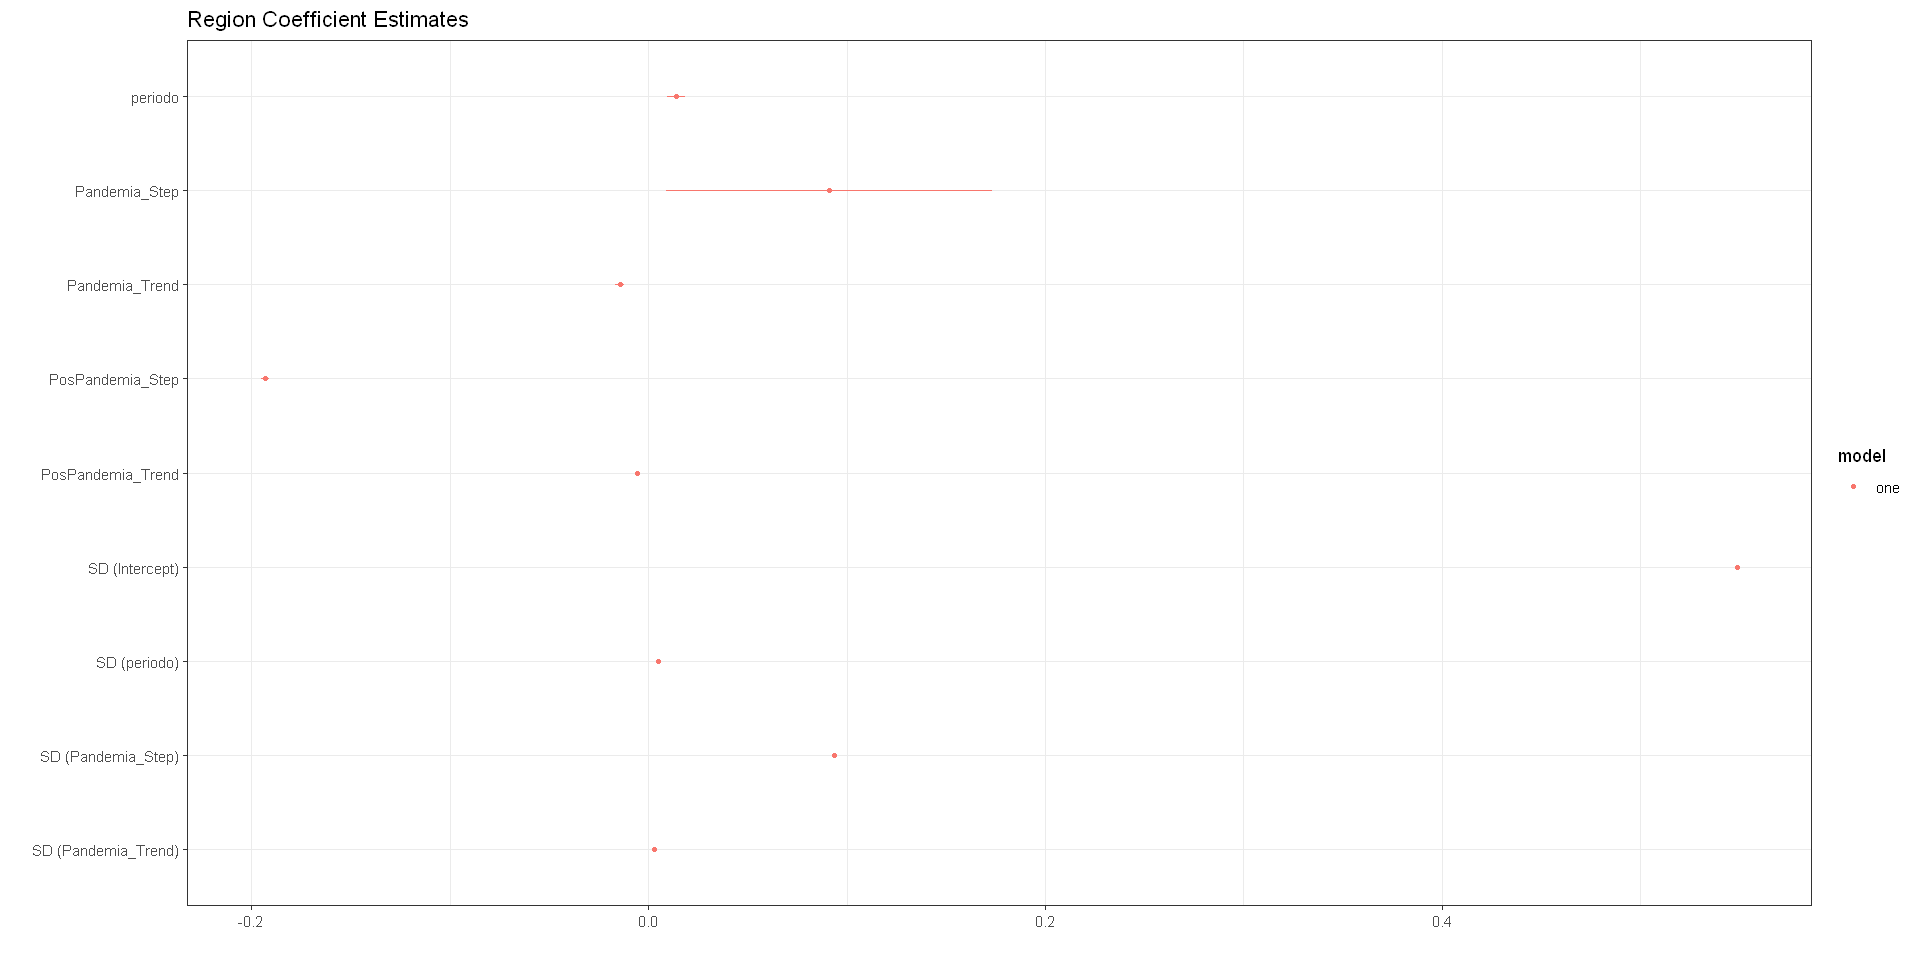

In [ ]:
dwplot(model, show_intercept = FALSE) +
  theme_bw() +
  ggtitle("Region Coefficient Estimates")


In [ ]:
# Get fixed effects with confidence intervals
# Get fixed effects
coef_table <- tidy(model, conf.int = TRUE, effects = "fixed")


# Filter for terms that exactly match REGIOES_LIST
region_coefs <- coef_table %>%
  filter(term %in% REGIOES_LIST) # Exact matching

# Print results
print(region_coefs)


# A tibble: 0 × 9
# ℹ 9 variables: effect <chr>, component <chr>, term <chr>, estimate <dbl>,
#   std.error <dbl>, statistic <dbl>, p.value <dbl>, conf.low <dbl>,
#   conf.high <dbl>


In [ ]:
# Get Random Effects
ranef(model)$cond$regiao # For conditional model (adjust if using zero-inflation)


,(Intercept),periodo,Pandemia_Step,Pandemia_Trend
,<dbl>,<dbl>,<dbl>,<dbl>
centro_oeste,0.2979733,-0.002604056,0.01016291,0.0002293900
nordeste,-0.6254816,0.007285852,0.10637063,-0.0027374576
norte,-0.6494205,0.003877494,-0.15953819,0.0050358049
sudeste,0.2351029,-0.001253439,0.07654239,-0.0005156312
sul,0.7413790,-0.007305743,-0.03355314,-0.0020121585


# other stuff


In [ ]:
preds <- ggpredict(model, terms = c("periodo", "regiao"))
# plot(preds) # Plot trends by region


Some of the focal terms are of type `character`. This may lead to
  unexpected results. It is recommended to convert these variables to
  factors before fitting the model.
  The following variables are of type character: `regiao`

Model uses a transformed offset term. Predictions may not be correct.
  It is recommended to fix the offset term using the `condition` argument,
  e.g. `condition = c(total_visits = 1)`.
  You could also transform the offset variable before fitting the model
  and use `offset(total_visits)` in the model formula.



In [ ]:
# Get region-specific intercepts and slopes
region_intercepts <- fixef(model)$cond[1] + ranef(model)$cond$regiao[, 1]
region_slopes <- fixef(model)$cond[2] + ranef(model)$cond$regiao[, 2]

# Calculate region-specific pandemic effects
pandemic_effects <- data.frame(
  Region = rownames(ranef(model)$cond$regiao),
  Intercept = exp(region_intercepts),
  Trend_During_Pandemic = fixef(model)$cond["Pandemia_Trend"] + ranef(model)$cond$regiao[, "periodo"]
)

print(pandemic_effects)


        Region Intercept Trend_During_Pandemic
1 centro_oeste 13.434152          -0.017005475
2     nordeste  5.335300          -0.007115567
3        norte  5.209096          -0.010523925
4      sudeste 12.615544          -0.015654857
5          sul 20.930465          -0.021707161


# Plot Regions

In [ ]:
# Alternative plot with observed vs predicted
options(repr.plot.width = 16, repr.plot.height = 8) # Para Jupyter Notebook/RMarkdown
regression_df$pred <- predict(model, type = "response")

ggplot(regression_df, aes(periodo, mental_health_visits / (total_visits / 1000), color = regiao)) +
  geom_point(alpha = 0.3) +
  geom_line(aes(y = pred / (total_visits / 1000)), size = 1) +
  facet_wrap(~regiao) +
  labs(
    title = "Observed vs Predicted Rates by Region",
    y = "Rate per 1000"
  )


ERROR: Error: objeto 'model' não encontrado


In [ ]:
fixef(model)$cond[c(
    "Pandemia_Step", "Pandemia_Trend",
    "PosPandemia_Step", "PosPandemia_Trend"
)]


Pandemia_Step    Pandemia_Trend  PosPandemia_Step PosPandemia_Trend 
      0.091300713      -0.014401419      -0.193271141      -0.005563008